## PROJET 6: CLASSIFICATION AUTOMATIQUE DE BIENS DE CONSOMMATION

### SOMMAIRE

PARTIE I: EXTRACTION FEATURES DES DONNEES TEXTES

PARTIE II: EXTRACTION FEATURES DES DONNEES IMAGES

PARTIE III: DATA AUGMENTATION, CLASSICIFICATION SUPERVISEE

PARTIE IV: CONCEPT D'UNE TECHNIQUE RECENTE ET SCRIPT PYTHON

PARTIE IV: APPROCHE COMBINEE, TEXTES ET IMAGES

L'idee ici est d'associer les features texte et image et de les etudier ensemble 

In [1]:
# les librairies 
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# les librairies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### partie A/ technique recente 

### a) <b>lecture fichier

In [3]:
# fonction lecture fichier csv
def read_csv(path_file):
    return pd.read_csv(path_file)

In [4]:
# lecture du df et affichage des cinq premières lignes
df=read_csv(r"/Users/saidali_bacar/Documents/projets openclassrooms/projet 6/df_projet6_pour_partie3.csv")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category,product_category2,cat_num,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,3,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,4,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel b...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,4,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,3,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,3,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...


la cible

In [5]:
l_cat = list(set(df["product_category"]))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]["product_category"])) for i in range(len(df))]
#y_cat_num

df["cat_num"] = [(l_cat.index(df.iloc[i]["product_category"])) for i in range(len(df))]
#df["cat_num"]

catégories :  ['Beauty and Personal Care ', 'Kitchen & Dining ', 'Home Furnishing ', 'Watches ', 'Home Decor & Festive Needs ', 'Computers ', 'Baby Care ']


In [6]:
X_NLP = np.load('X_NLP.csv.npy', allow_pickle=True)
X_img_vgg16 = np.load('X_img_vgg16.csv.npy', allow_pickle=True)

In [7]:
print('NLP : ', X_NLP.shape)
print('IMG : ', X_img_vgg16.shape)

NLP :  (1050, 4240)
IMG :  (1050, 4096)


Ici on a 4240 features pour le texte et 4096 pour les images 

assemblage des matrices 

In [8]:
X_combined = np.hstack([X_NLP, X_img_vgg16])

In [9]:
print('Combined : ', X_combined.shape)

Combined :  (1050, 8336)


les fonctions communes 

PCA, TSNE, Kmeans avec 7 clusters

In [10]:
import time
from sklearn.cluster import KMeans
from sklearn import manifold, decomposition
from sklearn import cluster, metrics

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)

    print("Dimensions dataset avant réduction PCA : ", X_combined.shape)
    pca = decomposition.PCA(n_components=0.99)
    feat_pca= pca.fit_transform(X_combined)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),7)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

visualisation

In [11]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    style="cluster",  # Additional marker customization based on cluster
    markers=['o', 's', 'D', '^', 'v', '<', '>'],  # Customize markers
    
    plt.show()
    print("ARI : ", ARI)

### faisabilite

ARI

In [12]:
print("VGG16 : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(X_combined)

VGG16 : 
--------
Dimensions dataset avant réduction PCA :  (1050, 8336)
Dimensions dataset après réduction PCA :  (1050, 803)
ARI :  0.4927456 time :  5.0


visualisation graphique 

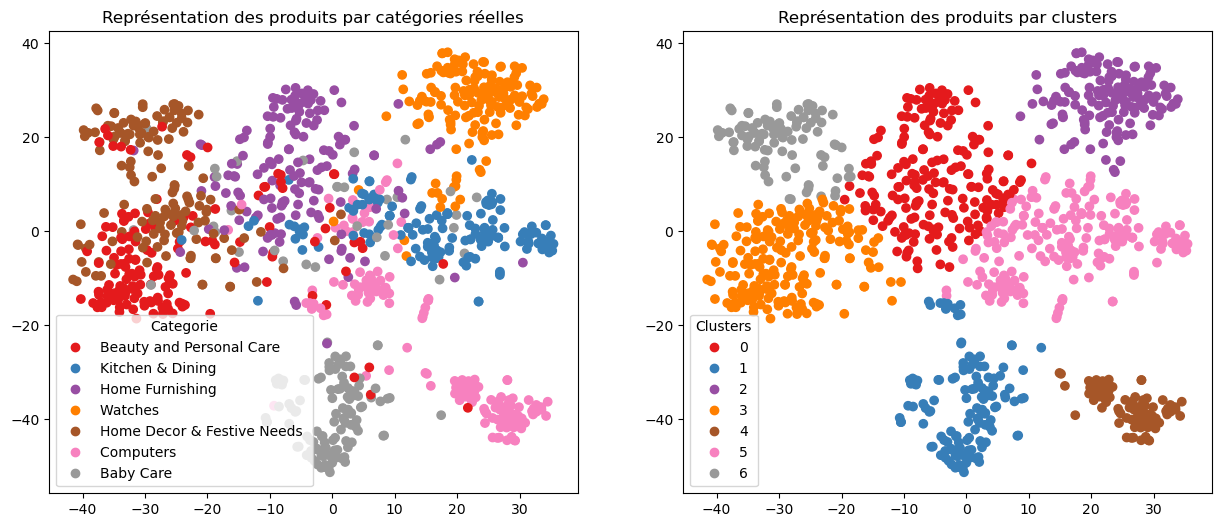

ARI :  0.4927456


In [13]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## classification supervisee

sans la data augmentation

### Création du modèle de classification

determination de X et y

In [14]:
X = X_combined
y = to_categorical(df['cat_num'], num_classes=7)

y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [15]:
# split en donnees d'entrainement et donnees de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(787, 8336)

creation et entrainement du modele

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    
    return model

# Create the model
num_classes =  7
input_shape = (8336,) 

# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
#model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

In [17]:
# Création du modèle
with tf.device('/gpu:0'): 
    model_comb = create_model(input_shape, num_classes)
    
# Création du callback
model_comb_save_path1 = "./model_comb_best_weights.h5"
checkpoint = ModelCheckpoint(model_comb_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history_comb = model_comb.fit(X_train, y_train, epochs=50, batch_size=32, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              8537088   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 9195015 (35.08 MB)
Trainable params: 91950

/Users/saidali_bacar/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/25 [========================>.....] - ETA: 0s - loss: 1.0729 - accuracy: 0.7530
Epoch 2: val_loss improved from 0.84808 to 0.56344, saving model to ./model_comb_best_weights.h5
25/25 [==============================] - 0s 11ms/step - loss: 1.1314 - accuracy: 0.7497 - val_loss: 0.5634 - val_accuracy: 0.8479
Epoch 3/50
21/25 [========================>.....] - ETA: 0s - loss: 0.7519 - accuracy: 0.7723
Epoch 3: val_loss improved from 0.56344 to 0.43408, saving model to ./model_comb_best_weights.h5
25/25 [==============================] - 0s 11ms/step - loss: 0.7227 - accuracy: 0.7764 - val_loss: 0.4341 - val_accuracy: 0.8669
Epoch 4/50
20/25 [=======================>......] - ETA: 0s - loss: 0.4981 - accuracy: 0.8438
Epoch 4: val_loss improved from 0.43408 to 0.42748, saving model to ./model_comb_best_weights.h5
25/25 [==============================] - 0s 11ms/step - loss: 0.4801 - accuracy: 0.8488 - val_loss: 0.4275 - val_accuracy: 0.8631
Epoch 5/50
25/25 [==============================

In [18]:
# Score du dernier epoch

loss, accuracy = model_comb.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model_comb.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

25/25 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9911
Training Accuracy: 0.9911

9/9 [==============================] - 0s 3ms/step - loss: 0.5725 - accuracy: 0.8783
Validation Accuracy:  0.8783


In [19]:
# Score de l'epoch optimal

model_comb.load_weights(model_comb_save_path1)

loss, accuracy = model_comb.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8935


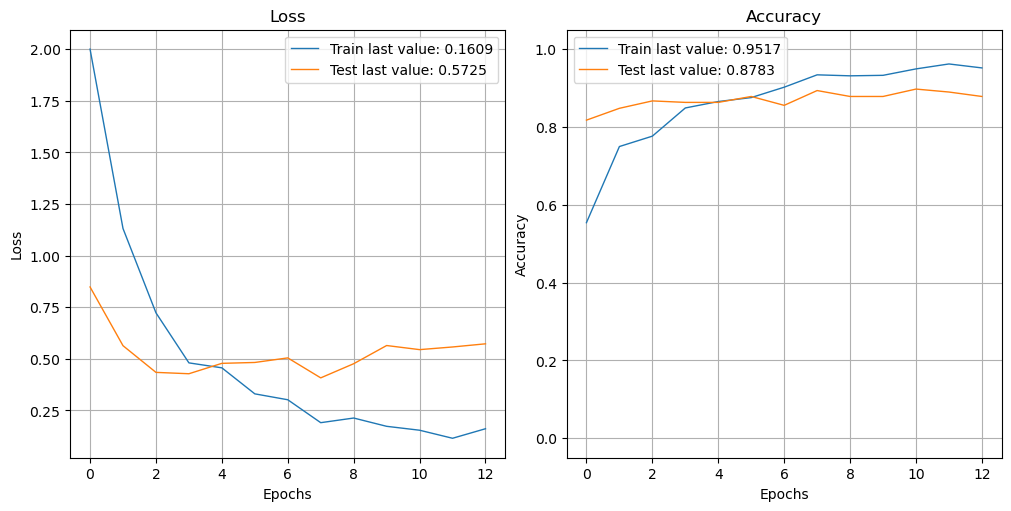

In [20]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history_comb)
plot_history(history_comb, path="standard.png")
plt.close()

matrice de confusion

In [21]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model_comb.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

9/9 [==============================] - 0s 3ms/step
[3 3 1 4 3 1 5 0 3 0 0 4 6 5 0 6 5 0 2 6 2 2 1 0 4 5 4 6 2 2 0 2 1 3 2 0 4
 0 0 1 6 6 1 1 4 4 0 6 2 3 1 2 3 6 1 4 6 1 4 0 1 6 5 1 0 6 5 3 6 0 3 4 0 0
 4 2 4 4 6 3 1 4 5 5 1 2 1 0 3 5 5 2 3 1 6 3 6 5 5 1 5 4 2 4 0 0 0 6 4 6 5
 0 4 5 5 6 1 4 2 1 4 0 3 3 2 3 4 2 0 3 3 0 5 1 3 3 1 5 0 1 0 3 5 2 0 1 5 6
 1 2 6 0 2 1 1 0 3 3 4 3 1 2 5 5 3 5 1 2 4 3 1 2 5 5 2 2 0 0 3 6 0 4 4 1 4
 4 1 3 6 3 6 5 2 5 0 2 2 1 6 2 0 6 4 3 3 5 3 4 1 4 0 5 5 5 2 5 6 3 6 4 6 2
 5 4 1 4 6 6 4 1 3 6 5 6 3 6 3 2 3 2 5 6 0 2 4 5 0 4 3 0 2 4 4 2 2 5 2 6 1
 6 6 2 1]

[3 3 1 4 3 1 5 0 3 0 0 4 6 5 0 6 5 0 2 6 2 2 1 0 4 5 4 6 2 2 1 5 1 3 2 0 5
 0 0 1 0 6 1 1 6 4 0 6 2 3 1 2 3 6 1 4 6 1 4 0 1 6 5 1 0 4 5 3 2 0 3 4 0 0
 4 2 4 4 2 3 1 1 5 5 1 5 1 0 3 5 5 2 3 1 6 3 2 5 5 1 5 4 2 4 5 0 0 6 4 6 5
 0 4 5 5 2 1 4 2 1 4 4 3 3 2 3 3 2 0 3 3 4 5 1 3 3 1 5 0 1 0 3 5 2 0 1 5 2
 1 2 2 0 2 1 1 0 3 3 4 3 1 2 5 5 3 5 1 2 4 3 1 2 5 5 2 2 0 0 3 6 0 4 4 1 5
 4 1 3 4 3 6 5 2 5 0 2 6 1 6 2 0 4 4 3

In [22]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [23]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[33  2  0  0  2  1  0]
 [ 0 36  0  0  0  0  1]
 [ 0  0 35  0  0  2  1]
 [ 0  0  0 38  0  0  0]
 [ 0  1  0  2 30  4  1]
 [ 0  0  0  0  0 37  0]
 [ 1  0  7  0  3  0 26]]


In [24]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[33  2  0  0  2  1  0]
 [ 0 36  0  0  0  0  1]
 [ 0  0 35  0  0  2  1]
 [ 0  0  0 38  0  0  0]
 [ 0  1  0  2 30  4  1]
 [ 0  0  0  0  0 37  0]
 [ 1  0  7  0  3  0 26]]

              precision    recall  f1-score   support

           0       0.97      0.87      0.92        38
           1       0.92      0.97      0.95        37
           2       0.83      0.92      0.88        38
           3       0.95      1.00      0.97        38
           4       0.86      0.79      0.82        38
           5       0.84      1.00      0.91        37
           6       0.90      0.70      0.79        37

    accuracy                           0.89       263
   macro avg       0.90      0.89      0.89       263
weighted avg       0.90      0.89      0.89       263



<Axes: >

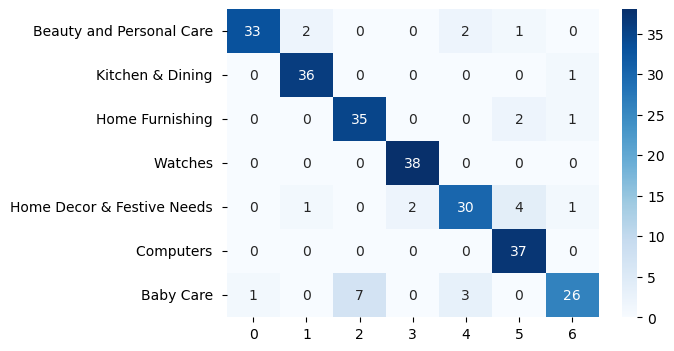

In [25]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in set(df["product_category"])],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

### partie B/ les regles du RGPD

article reference cabinet base a Lyon, specialise dans la protection des donnees 

https://www.xdpo.fr/post/les-10-regles-d-or-du-rgpd

aller plus loin

tranformers, attention is all you need (par ex BERT, predire le prochain mot)
low rank adaptation
LLM 